In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
tf.get_logger().setLevel('INFO')

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

mpl.rcParams['figure.figsize'] = 20, 10

import sys
sys.path.append('../utils/')
import time_series_utils

Using TensorFlow backend.


In [2]:
def tilted_loss(q, y, f):
    #e = (y - f)
    e = (f - y)
    return keras.backend.mean(keras.backend.maximum(q * e, (q - 1) * e), axis=-1)

In [3]:
def lstm_dqr_model(X, ts_Y_train, n_steps, n_features, q):
    # define model
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adagrad', loss=lambda y, f: tilted_loss(q, y, f))
    # fit model
    model.fit(X, ts_Y_train, epochs=200, verbose=0)
    return model

In [4]:
def lstm_model(X, ts_Y_train, n_steps, n_features):
    # define model
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    # fit model
    model.fit(X, ts_Y_train, epochs=200, verbose=0)
    return model

In [5]:
def plot_ts_forecast(ts_Y_train, ts_Y_test, yhat):
    forecast_h = len(yhat)
    train_window = len(ts_Y_train)
    x_length = forecast_h+train_window
    aa=[x for x in range(x_length)]
    plt.figure(figsize=(20,8))
    plt.plot(aa[:train_window], ts_Y_train, marker='.', label="train")
    plt.plot(aa[train_window:], ts_Y_test, marker='.', label="test")
    plt.plot(aa[train_window:], yhat.reshape(-1), 'r', label="prediction")
    plt.tight_layout()
    plt.subplots_adjust(left=0.07)
    plt.xlabel('time step', size=15)
    plt.legend(fontsize=15)
    plt.show()

In [6]:
# ------Time series
t0 = '2016-01-01 00:00:00'
freq = 'H'
num_ts = 1

# default - changed in each experiemnt to test different behaviors
noise_level = 0.05
period = 14

# train, test
total_days = 20
tseries_length = total_days * 24 # hourly freq
train_days = 15 * 24

# ------LSTM
n_features = 1 # We are working with univariate series so the number of features is 1
n_steps=2 # we will work with a batch of 2 time steps

# ----- Deep Quantile Regression
QUANTILES = [0.1, 0.3, 0.5, 0.7, 0.9]
q = 0.5

In [7]:
time_series_df = time_series_utils.generate_synth_tseries(t0, tseries_length, num_ts, period, freq, noise_level)

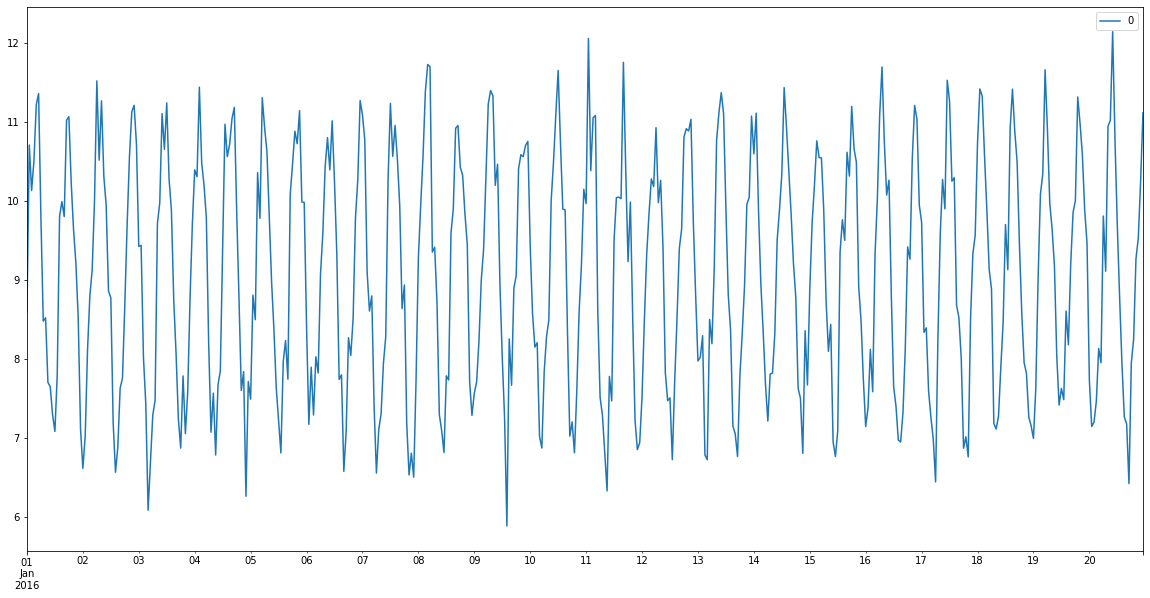

In [8]:
time_series_df.T.plot()

In [9]:
train_ts = time_series_df.iloc[:, 0:train_days]
test_ts = time_series_df.iloc[:,train_days-1:-1]
ts_X_test, ts_Y_test = time_series_utils.split_sequence(test_ts.values[0], n_steps)
ts_X_train, ts_Y_train = time_series_utils.split_sequence(train_ts.values[0], n_steps)
# reshape as input for the lstm
X = ts_X_train.reshape((ts_X_train.shape[0], ts_X_train.shape[1], n_features)) #  sequence lenght, n_steps and features per time step

In [10]:
#model = lstm_dqr_model(X, ts_Y_train, n_steps, n_features, q)
model = lstm_model(X, ts_Y_train, n_steps, n_features)





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [11]:
# demonstrate prediction
x_input = ts_X_test
x_input = x_input.reshape((ts_X_test.shape[0], ts_X_test.shape[1], n_features))
yhat = model.predict(x_input, verbose=0)

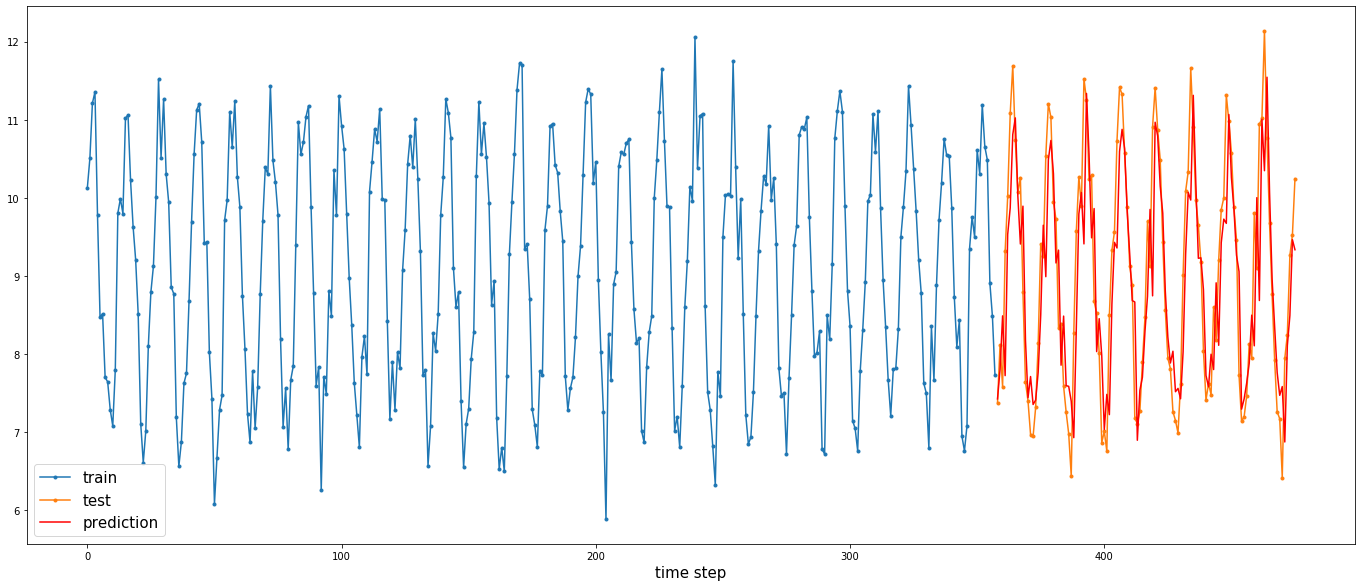

In [12]:
plot_ts_forecast(ts_Y_train, ts_Y_test, yhat)